
# M&A Impact Analysis Using OpenBB


This notebook demonstrates an analysis of Mergers and Acquisitions (M&A) impact on stock performance using OpenBB's historical data. The analysis includes calculating key performance metrics for the acquirer, pre- and post-announcement, and visualizes the results. It aims to assess how M&A announcements affect stock return, volatility, and beta over time.

Author:<br>
[Nabid Akhtar](https://github.com/NabidAkhtar)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenBB-Finance/OpenBB/blob/develop/examples/M_A_Impact_Analysis_Notebook.ipynb)


    

## Table of Contents

1. **Imports and Setup**  
    Import necessary libraries and set up functions for data retrieval and analysis.
    
2. **Function Definitions**
    - `get_stock_performance`: Retrieves stock data and calculates key metrics.
    - `analyze_ma_impact`: Analyzes pre- and post-M&A performance.
    - `plot_ma_analysis`: Visualizes cumulative returns and metric comparisons.
    - `generate_ma_report`: Generates a formatted analysis report.

3. **Running Analysis**  
    Execute the analysis by specifying acquirer and target tickers, announcement date, and other parameters.

4. **Visualizing and Reporting Results**  
    Display the visual analysis and generate a summary report.

If you are running this notebook in Colab, you can run the following command to install the OpenBB Platform:

```python
!pip install openbb matplotlib
```


## 1. Imports and Setup

In [1]:

from openbb import obb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


## 2. Function Definitions

### Fetch Stock Performance Data

In [2]:
def get_stock_performance(ticker, start_date, end_date):
    """
    Fetches stock price data and calculates key performance metrics
    
    Parameters:
    ticker (str): Stock ticker symbol
    start_date (str): Start date in YYYY-MM-DD format
    end_date (str): End date in YYYY-MM-DD format
    
    Returns:
    dict: Performance metrics including returns, volatility, and beta
    """
    try:
        # Get historical price data and convert to DataFrame
        stock_data = obb.equity.price.historical(ticker, start_date, end_date).to_df()
        
        if len(stock_data) == 0:
            print(f"No data available for {ticker}")
            return None
            
        # Calculate daily returns using 'close' price
        stock_data['returns'] = stock_data['close'].pct_change()
        
        # Get market data (S&P 500)
        spy_data = obb.equity.price.historical('SPY', start_date, end_date).to_df()
        spy_data['returns'] = spy_data['close'].pct_change()
        
        # Calculate metrics
        first_price = stock_data['close'].iloc[0]
        last_price = stock_data['close'].iloc[-1]
        total_return = ((last_price / first_price) - 1) * 100
        volatility = stock_data['returns'].std() * np.sqrt(252) * 100
        
        # Calculate beta using aligned data
        merged_data = pd.DataFrame({
            'stock': stock_data['returns'],
            'market': spy_data['returns']
        }).dropna()
        
        if len(merged_data) > 0:
            beta = np.cov(merged_data['stock'], merged_data['market'])[0][1] / np.var(merged_data['market'])
        else:
            beta = np.nan
        
        return {
            'total_return': total_return,
            'volatility': volatility,
            'beta': beta,
            'daily_returns': stock_data['returns']
        }
    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        import traceback
        print(traceback.format_exc())
        return None

### Analyze M&A Impact

In [3]:
def analyze_ma_impact(acquirer_ticker, target_ticker, announcement_date, window_size=180):
    """
    Analyzes the impact of M&A announcement on company performance
    
    Parameters:
    acquirer_ticker (str): Acquirer company ticker
    target_ticker (str): Target company ticker
    announcement_date (str): M&A announcement date in YYYY-MM-DD format
    window_size (int): Analysis window in days before and after announcement
    
    Returns:
    dict: Analysis results including pre and post merger performance metrics
    """
    try:
        # Parse dates
        announcement_dt = datetime.strptime(announcement_date, '%Y-%m-%d')
        pre_start = (announcement_dt - timedelta(days=window_size)).strftime('%Y-%m-%d')
        pre_end = announcement_date
        post_start = announcement_date
        post_end = (announcement_dt + timedelta(days=window_size)).strftime('%Y-%m-%d')
        
        print(f"Analyzing pre-merger period: {pre_start} to {pre_end}")
        pre_merger = get_stock_performance(acquirer_ticker, pre_start, pre_end)
        
        if pre_merger is None:
            print("Unable to analyze pre-merger performance")
            return None
        
        print(f"Analyzing post-merger period: {post_start} to {post_end}")
        post_merger = get_stock_performance(acquirer_ticker, post_start, post_end)
        
        if post_merger is None:
            print("Unable to analyze post-merger performance")
            return None
        
        return {
            'pre_merger': pre_merger,
            'post_merger': post_merger,
            'impact': {
                'return_change': post_merger['total_return'] - pre_merger['total_return'],
                'volatility_change': post_merger['volatility'] - pre_merger['volatility'],
                'beta_change': post_merger['beta'] - pre_merger['beta']
            }
        }
    except Exception as e:
        print(f"Error in analysis: {str(e)}")
        return None


### Plot Analysis Results

In [4]:
def plot_ma_analysis(analysis_results, acquirer_ticker, announcement_date):
    """
    Creates visualizations for M&A impact analysis
    
    Parameters:
    analysis_results (dict): Results from analyze_ma_impact function
    acquirer_ticker (str): Acquirer company ticker
    announcement_date (str): M&A announcement date
    """
    if analysis_results is None:
        print("No analysis results to plot")
        return
        
    try:
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Cumulative Returns
        plt.subplot(2, 2, 1)
        pre_cum_returns = (1 + analysis_results['pre_merger']['daily_returns']).cumprod()
        post_cum_returns = (1 + analysis_results['post_merger']['daily_returns']).cumprod()
        
        plt.plot(range(-len(pre_cum_returns), 0), pre_cum_returns, label='Pre-merger')
        plt.plot(range(len(post_cum_returns)), post_cum_returns, label='Post-merger')
        plt.axvline(x=0, color='r', linestyle='--', label='Announcement')
        plt.title(f'Cumulative Returns Around M&A Announcement\n{acquirer_ticker}')
        plt.xlabel('Days from Announcement')
        plt.ylabel('Cumulative Return')
        plt.legend()
        
        # Plot 2: Key Metrics Comparison
        plt.subplot(2, 2, 2)
        metrics = ['total_return', 'volatility', 'beta']
        pre_values = [analysis_results['pre_merger'][m] for m in metrics]
        post_values = [analysis_results['post_merger'][m] for m in metrics]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        plt.bar(x - width/2, pre_values, width, label='Pre-merger')
        plt.bar(x + width/2, post_values, width, label='Post-merger')
        plt.xticks(x, metrics)
        plt.title('Key Metrics Comparison')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in plotting: {str(e)}")


### Generate Summary Report

In [5]:
def generate_ma_report(analysis_results, acquirer_ticker, target_ticker, announcement_date):
    """
    Generates a summary report of the M&A impact analysis
    
    Parameters:
    analysis_results (dict): Results from analyze_ma_impact function
    acquirer_ticker (str): Acquirer company ticker
    target_ticker (str): Target company ticker
    announcement_date (str): M&A announcement date
    
    Returns:
    str: Formatted report text
    """
    if analysis_results is None:
        return "Unable to generate report due to missing analysis results"
        
    try:
        report = f"""
M&A Impact Analysis Report
=========================
Acquirer: {acquirer_ticker}
Target: {target_ticker}
Announcement Date: {announcement_date}

Performance Metrics
-----------------
Pre-Merger Period:
- Total Return: {analysis_results['pre_merger']['total_return']:.2f}%
- Volatility: {analysis_results['pre_merger']['volatility']:.2f}%
- Beta: {analysis_results['pre_merger']['beta']:.2f}

Post-Merger Period:
- Total Return: {analysis_results['post_merger']['total_return']:.2f}%
- Volatility: {analysis_results['post_merger']['volatility']:.2f}%
- Beta: {analysis_results['post_merger']['beta']:.2f}

Impact Analysis
--------------
- Return Impact: {analysis_results['impact']['return_change']:.2f}%
- Volatility Impact: {analysis_results['impact']['volatility_change']:.2f}%
- Beta Impact: {analysis_results['impact']['beta_change']:.2f}

Summary
-------
The merger announcement appears to have {
    'positively' if analysis_results['impact']['return_change'] > 0 else 'negatively'
} impacted the acquirer's stock performance, with a {
    abs(analysis_results['impact']['return_change']):.2f}% change in returns.
Risk metrics show that the company's volatility has {
    'increased' if analysis_results['impact']['volatility_change'] > 0 else 'decreased'
} by {abs(analysis_results['impact']['volatility_change']):.2f}% and beta has {
    'increased' if analysis_results['impact']['beta_change'] > 0 else 'decreased'
} by {abs(analysis_results['impact']['beta_change']):.2f}.
"""
        return report
    except Exception as e:
        return f"Error generating report: {str(e)}"


## 3. Running Analysis

In [9]:

# Example usage
analysis_results = analyze_ma_impact("MSFT", "LNKD", "2016-06-13")


Analyzing pre-merger period: 2015-12-16 to 2016-06-13
Analyzing post-merger period: 2016-06-13 to 2016-12-10


## 4. Visualizing and Reporting Results

### Plot Analysis Results

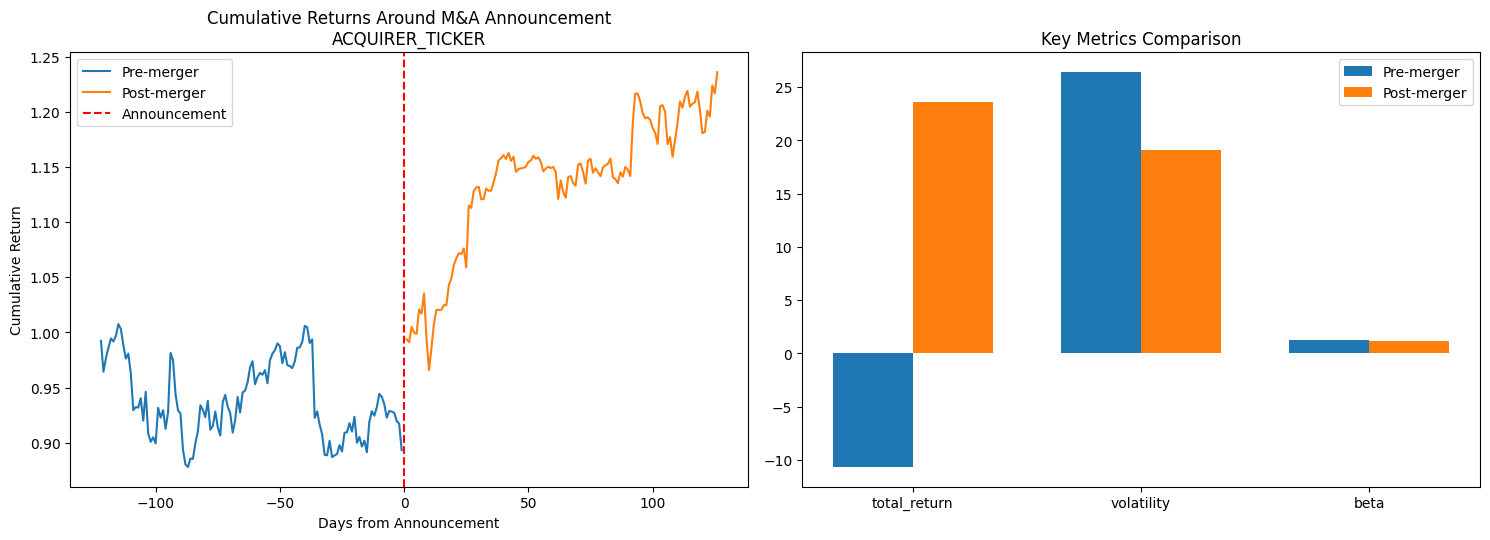

In [10]:

# Plot the analysis results
plot_ma_analysis(analysis_results, "ACQUIRER_TICKER", "ANNOUNCEMENT_DATE")


### Generate Summary Report

In [11]:

# Generate and print the summary report
print(generate_ma_report(analysis_results, "ACQUIRER_TICKER", "TARGET_TICKER", "ANNOUNCEMENT_DATE"))



M&A Impact Analysis Report
Acquirer: ACQUIRER_TICKER
Target: TARGET_TICKER
Announcement Date: ANNOUNCEMENT_DATE

Performance Metrics
-----------------
Pre-Merger Period:
- Total Return: -10.67%
- Volatility: 26.41%
- Beta: 1.25

Post-Merger Period:
- Total Return: 23.59%
- Volatility: 19.10%
- Beta: 1.15

Impact Analysis
--------------
- Return Impact: 34.27%
- Volatility Impact: -7.30%
- Beta Impact: -0.10

Summary
-------
The merger announcement appears to have positively impacted the acquirer's stock performance, with a 34.27% change in returns.
Risk metrics show that the company's volatility has decreased by 7.30% and beta has decreased by 0.10.




---

### Conclusion

The notebook provides a streamlined approach to assessing M&A impact, leveraging OpenBB's data retrieval capabilities to analyze stock performance pre- and post-announcement.
